# 🛍️ Project Notebook
Section UU
- Vanessa DiPietrantonio 40189938
- Michaël Gugliandolo 40213419
- Jessey Thach 40210440
- Mahanaim Rubin Yo 40178119

## 📥 Part 1: Data Preprocessing
Steps:
- Load `ecommerce_user_data.csv` and `product_details.csv`
- Merge data if necessary
- Create user-item matrix
- Fill missing ratings with 0
- Group user behavior by category

In [25]:
# Load data
import pandas as pd

user_data = pd.read_csv('data/ecommerce_user_data.csv')
product_data = pd.read_csv('data/product_details.csv')

print("Datasets:")
print(user_data.head())
print(product_data.head())

Datasets:
  UserID ProductID  Rating   Timestamp  Category
0   U000     P0009       5  2024-09-08     Books
1   U000     P0020       1  2024-09-02      Home
2   U000     P0012       4  2024-10-18     Books
3   U000     P0013       1  2024-09-18  Clothing
4   U000     P0070       4  2024-09-16      Toys
  ProductID      ProductName     Category
0     P0000      Toys Item 0     Clothing
1     P0001  Clothing Item 1  Electronics
2     P0002     Books Item 2  Electronics
3     P0003  Clothing Item 3  Electronics
4     P0004  Clothing Item 4  Electronics


In [26]:
# Merge datasets on ProductID to get complete info
data = pd.merge(user_data, product_data, on='ProductID', how='left')
print("Merged datasets:")
print(data.head())

Merged datasets:
  UserID ProductID  Rating   Timestamp Category_x       ProductName Category_y
0   U000     P0009       5  2024-09-08      Books   Clothing Item 9      Books
1   U000     P0020       1  2024-09-02       Home  Clothing Item 20       Home
2   U000     P0012       4  2024-10-18      Books    Beauty Item 12      Books
3   U000     P0013       1  2024-09-18   Clothing  Clothing Item 13   Clothing
4   U000     P0070       4  2024-09-16       Toys    Beauty Item 70       Toys


In [27]:
# Create user-item matrix
user_item_matrix = user_data.pivot_table(index='UserID', columns='ProductID', values='Rating')
user_item_matrix_filled = user_item_matrix.fillna(0)
print("User-item matrix:")
print(user_item_matrix_filled.head())

User-item matrix:
ProductID  P0000  P0001  P0002  P0003  P0004  P0005  P0006  P0007  P0008  \
UserID                                                                     
U000         0.0    0.0    0.0    3.0    0.0    5.0    0.0    3.0    0.0   
U001         0.0    0.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0   
U002         0.0    0.0    0.0    0.0    0.0    5.0    0.0    0.0    0.0   
U003         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
U004         0.0    3.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0   

ProductID  P0009  ...  P0090  P0091  P0092  P0093  P0094  P0095  P0096  P0097  \
UserID            ...                                                           
U000         5.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
U001         0.0  ...    0.0    5.0    0.0    0.0    0.0    3.0    0.0    0.0   
U002         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
U003         0.0  ...    0.0    0.0    0.0  

In [28]:
# Aggregate user behavior by category
user_category_agg = user_data.groupby(['UserID', 'Category']).agg({'Rating': ['count', 'mean']}).reset_index()
user_category_agg.columns = ['UserID', 'Category', 'TotalInteractions', 'AverageRating']
print("User category aggregation:")
print(user_category_agg.head())

User category aggregation:
  UserID     Category  TotalInteractions  AverageRating
0   U000        Books                  6       3.666667
1   U000     Clothing                  3       1.666667
2   U000  Electronics                  3       3.666667
3   U000         Home                  2       1.000000
4   U000         Toys                  6       3.500000


## 🤝 Part 2: User-Based Collaborative Filtering
Steps:
- Use cosine similarity to compare users
- Recommend top-N products based on similar users
- Evaluate with Precision@K and Coverage

In [29]:
# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(user_item_matrix_filled)
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix_filled.index, columns=user_item_matrix_filled.index)
print("User similarity matrix:")
print(similarity_df.head())

# Uncomment these lines to get the average cosine similarity of the top 8 most similar users to each user
# np.fill_diagonal(similarity_matrix, -1)
# top_avg_similarities = np.mean(np.sort(similarity_matrix, axis=1)[:, -8:], axis=1)
# print(top_avg_similarities.mean())

User similarity matrix:
UserID      U000      U001      U002      U003      U004      U005      U006  \
UserID                                                                         
U000    1.000000  0.063071  0.195522  0.023466  0.065412  0.161251  0.160096   
U001    0.063071  1.000000  0.190861  0.000000  0.111332  0.009540  0.000000   
U002    0.195522  0.190861  1.000000  0.065094  0.111662  0.050830  0.027756   
U003    0.023466  0.000000  0.065094  1.000000  0.035737  0.104116  0.026650   
U004    0.065412  0.111332  0.111662  0.035737  1.000000  0.159064  0.057144   

UserID      U007      U008      U009  ...      U040      U041      U042  \
UserID                                ...                                 
U000    0.092083  0.238263  0.274844  ...  0.241693  0.129483  0.156790   
U001    0.172286  0.167460  0.017593  ...  0.121540  0.024075  0.097953   
U002    0.055877  0.000000  0.181229  ...  0.144756  0.000000  0.217465   
U003    0.000000  0.025384  0.288009  ..

In [36]:
# Create recommendation function
# Find most similar user, recommend products they rated highly that target user hasn’t rated

# Get top-n most similar users
def get_top_similar_users(user_id, similarity_matrix, n=8):
    similar_scores = similarity_matrix.loc[user_id].drop(user_id)
    top_users = similar_scores.nlargest(n).index.tolist()
    return top_users

# Generate product recommendations
def recommend_products(user_id, matrix, similarity_matrix, product_data, n_similar=8, top_n=5, return_details=False, weighted=True):
    top_users = get_top_similar_users(user_id, similarity_matrix, n=n_similar)
    similar_ratings = matrix.loc[top_users]

    # Get the similarity scores of the most similar users
    similarity_values = similarity_matrix.loc[user_id][top_users]
    # Multiply their ratings by their similarity to get a pseudo-weighted average (higher similarity leads to higher score)
    weighted_ratings = similar_ratings.multiply(similarity_values, axis=0)
    user_rated = matrix.loc[user_id]

    scores = {}
    for product in matrix.columns:
        if user_rated[product] != 0:
            continue

        # Only consider similar users that have rated this product to ignore zeros
        if weighted:
            filtered_ratings = weighted_ratings[product][weighted_ratings[product] > 0]
        else:
            filtered_ratings = similar_ratings[product][similar_ratings[product] > 0]

        if filtered_ratings.any():
            scores[product] = filtered_ratings.mean()

    sorted_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

    if return_details:
        # Convert to dataframe for details
        rec_df = pd.DataFrame(sorted_items, columns=['ProductID', 'RecScore'])
        recommend_products = rec_df.merge(product_data, on='ProductID', how='left')
        return recommend_products
    else:
        return [product for product, score in sorted_items]

example_user = user_item_matrix.index[0]
print(f"Top recommendations for {example_user} using user-based collaborative filtering:")
print(recommend_products(example_user, user_item_matrix_filled, similarity_df, product_data, return_details=True))

Top recommendations for U000 using user-based collaborative filtering:
  ProductID  RecScore          ProductName     Category
0     P0029  1.873662        Books Item 29  Electronics
1     P0064  1.441261  Electronics Item 64  Electronics
2     P0083  1.429176       Beauty Item 83       Beauty
3     P0040  1.247448  Electronics Item 40         Home
4     P0023  1.208463         Home Item 23     Clothing


Evaluation functions using long form test set

In [7]:
# Implement evaluation metrics like Precision@K and Coverage, comparing recommended vs actual rated items

import numpy as np

# Evaluation Functions
def precision_at_k(recommended, relevant, k=5):
    recommended_k = recommended[:k]
    if not relevant:
        return 0.0
    return len(set(recommended_k) & set(relevant)) / k

def recall_at_k(recommended, relevant, k=5):
    recommended_k = recommended[:k]
    if not relevant:
        return 0.0
    return len(set(recommended_k) & set(relevant)) / len(relevant)

def average_precision(recommended, relevant, k=5):
    hits = 0
    sum_precisions = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            hits += 1
            sum_precisions += hits / (i + 1)
    return sum_precisions / hits if hits > 0 else 0.0

def coverage_score(recommendations, total_items):
    recommended_items = set(item for recs in recommendations.values() for item in recs)
    return len(recommended_items) / total_items

def diversity_score(recommendations, product_metadata):
    diversity_scores = []
    for recs in recommendations.values():
        categories = product_metadata[product_metadata['ProductID'].isin(recs)]['Category'].tolist()
        unique_cats = len(set(categories))
        total = len(categories)
        score = unique_cats / total if total > 0 else 0
        diversity_scores.append(score)
    return np.mean(diversity_scores)

In [30]:
# Train/Test Split for Evaluation
from sklearn.model_selection import train_test_split

ratings_long = user_item_matrix.stack().reset_index()
ratings_long.columns = ['UserID', 'ProductID', 'Rating']

train_data = []
test_data = []

for user in ratings_long['UserID'].unique():
    user_ratings = ratings_long[ratings_long['UserID'] == user]
    if len(user_ratings) >= 5:
        train, test = train_test_split(user_ratings, test_size=0.2, random_state=42)
        train_data.append(train)
        test_data.append(test)
    else:
        train_data.append(user_ratings)

train_df = pd.concat(train_data)
test_df = pd.concat(test_data)

train_matrix = train_df.pivot_table(index='UserID', columns='ProductID', values='Rating').fillna(0)
train_similarity_df = pd.DataFrame(
    cosine_similarity(train_matrix),
    index=train_matrix.index,
    columns=train_matrix.index
)
print("Training data - user similarity matrix:")
print(train_similarity_df.head())

Training data - user similarity matrix:
UserID      U000      U001      U002      U003      U004      U005      U006  \
UserID                                                                         
U000    1.000000  0.091062  0.065128  0.023918  0.096257  0.018487  0.112110   
U001    0.091062  1.000000  0.280976  0.000000  0.158388  0.011631  0.000000   
U002    0.065128  0.280976  1.000000  0.101477  0.125656  0.000000  0.039637   
U003    0.023918  0.000000  0.101477  1.000000  0.053838  0.000000  0.038211   
U004    0.096257  0.158388  0.125656  0.053838  1.000000  0.031209  0.000000   

UserID      U007      U008      U009  ...      U040      U041      U042  \
UserID                                ...                                 
U000    0.120495  0.281059  0.085113  ...  0.264146  0.148865  0.000000   
U001    0.075810  0.086258  0.000000  ...  0.107534  0.031220  0.134433   
U002    0.042601  0.000000  0.077379  ...  0.098883  0.000000  0.000000   
U003    0.000000  0.0373

In [31]:
# Compute Metrics
precision_scores = []
recall_scores = []
map_scores = []
user_rec_items = {}

precision_scores_weighted = []
recall_scores_weighted = []
map_scores_weighted = []
user_rec_items_weighted = {}

precision_scores_list = []
recall_scores_list = []
map_scores_list = []
coverage_list = []
diversity_list = []

precision_scores_list_weighted = []
recall_scores_list_weighted = []
map_scores_list_weighted = []
coverage_list_weighted = []
diversity_list_weighted = []

n_similar_users = 14
print(f"Recommendations based on the top {n_similar_users} similar users.")

test_users = test_df['UserID'].unique()

# Vary K to find better values
ks_user = range(1, 8, 2)

for k in ks_user:
    top_n_recs = k

    # Compute metrics for each user
    for user in test_users:
        if user not in train_matrix.index:
            continue

        user_test_data = test_df[(test_df['UserID'] == user) & (test_df['Rating'] >= 3)]
        relevant_items = user_test_data['ProductID'].tolist()

        # Get recommendations without weighting based on user similarity scores
        recs = recommend_products(user, train_matrix, train_similarity_df, product_data, n_similar = n_similar_users, top_n = top_n_recs, weighted=False)
        user_rec_items[user] = recs

        precision_scores.append(precision_at_k(recs, relevant_items, k))
        recall_scores.append(recall_at_k(recs, relevant_items, k))
        map_scores.append(average_precision(recs, relevant_items, k))

        # Repeat with recommendations weighted on user similarity scores
        recs = recommend_products(user, train_matrix, train_similarity_df, product_data, n_similar = n_similar_users, top_n = top_n_recs, weighted=True)
        user_rec_items_weighted[user] = recs

        precision_scores_weighted.append(precision_at_k(recs, relevant_items, k))
        recall_scores_weighted.append(recall_at_k(recs, relevant_items, k))
        map_scores_weighted.append(average_precision(recs, relevant_items, k))

    # Compute coverage and diversity
    total_unique_items = product_data['ProductID'].nunique()
    coverage = coverage_score(user_rec_items, total_unique_items)
    diversity = diversity_score(user_rec_items, product_data)

    coverage_weighted = coverage_score(user_rec_items_weighted, total_unique_items)
    diversity_weighted = diversity_score(user_rec_items_weighted, product_data)

    evaluation_results = {
        f"Precision@{k}": round(np.mean(precision_scores), 4),
        f"Recall@{k}": round(np.mean(recall_scores), 4),
        f"MAP@{k}": round(np.mean(map_scores), 4),
        "Coverage": round(coverage, 4),
        "Diversity": round(diversity, 4)
    }
    evaluation_results_weighted = {
        f"Precision@{k}": round(np.mean(precision_scores_weighted), 4),
        f"Recall@{k}": round(np.mean(recall_scores_weighted), 4),
        f"MAP@{k}": round(np.mean(map_scores_weighted), 4),
        "Coverage": round(coverage_weighted, 4),
        "Diversity": round(diversity_weighted, 4)
    }

    # Add results to list to graph them later
    precision_scores_list.append(np.mean(precision_scores))
    recall_scores_list.append(np.mean(recall_scores))
    map_scores_list.append(np.mean(map_scores))
    coverage_list.append(coverage)
    diversity_list.append(diversity)

    precision_scores_list_weighted.append(np.mean(precision_scores_weighted))
    recall_scores_list_weighted.append(np.mean(recall_scores_weighted))
    map_scores_list_weighted.append(np.mean(map_scores_weighted))
    coverage_list_weighted.append(coverage_weighted)
    diversity_list_weighted.append(diversity_weighted)

    print(f"\n--- Evaluation Summary With K={k} ---")
    for name, v in evaluation_results.items():
        print(f"{name}: {v:.4f}")

    print(f"\n--- Evaluation Summary With K={k}, Weighted ---")
    for name, v in evaluation_results_weighted.items():
        print(f"{name}: {v:.4f}")

Recommendations based on the top 14 similar users.

--- Evaluation Summary With K=1 ---
Precision@1: 0.0600
Recall@1: 0.0367
MAP@1: 0.0600
Coverage: 0.1700
Diversity: 1.0000

--- Evaluation Summary With K=1, Weighted ---
Precision@1: 0.0800
Recall@1: 0.0450
MAP@1: 0.0800
Coverage: 0.3000
Diversity: 1.0000

--- Evaluation Summary With K=3 ---
Precision@3: 0.0567
Recall@3: 0.0583
MAP@3: 0.0783
Coverage: 0.4200
Diversity: 0.8533

--- Evaluation Summary With K=3, Weighted ---
Precision@3: 0.0667
Recall@3: 0.0617
MAP@3: 0.0950
Coverage: 0.6500
Diversity: 0.8933

--- Evaluation Summary With K=5 ---
Precision@5: 0.0511
Recall@5: 0.0711
MAP@5: 0.0863
Coverage: 0.5700
Diversity: 0.7520

--- Evaluation Summary With K=5, Weighted ---
Precision@5: 0.0578
Recall@5: 0.0728
MAP@5: 0.1030
Coverage: 0.8700
Diversity: 0.7440

--- Evaluation Summary With K=7 ---
Precision@7: 0.0483
Recall@7: 0.0862
MAP@7: 0.0935
Coverage: 0.7100
Diversity: 0.6314

--- Evaluation Summary With K=7, Weighted ---
Precision@7

## 🔍 Part 3: Association Rule Mining (Apriori)
Steps:
- Convert user-product interactions to transaction format
- Apply Apriori algorithm to find frequent itemsets
- Generate association rules (support, confidence, lift)

In [32]:
# Convert to transaction format
from mlxtend.preprocessing import TransactionEncoder
transactions = user_data.groupby('UserID')['ProductID'].apply(list).tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)
print("DataFrame from TransactionEncoder:")
print(df_trans.head())

DataFrame from TransactionEncoder:
   P0000  P0001  P0002  P0003  P0004  P0005  P0006  P0007  P0008  P0009  ...  \
0  False  False  False   True  False   True  False   True  False   True  ...   
1  False  False   True  False  False  False  False  False  False  False  ...   
2  False  False  False  False  False   True  False  False  False  False  ...   
3  False  False  False  False  False  False  False  False  False  False  ...   
4  False   True  False  False  False  False   True  False  False  False  ...   

   P0090  P0091  P0092  P0093  P0094  P0095  P0096  P0097  P0098  P0099  
0  False  False  False  False  False  False  False  False  False  False  
1  False   True  False  False  False   True  False  False  False  False  
2  False  False  False  False  False  False  False  False  False  False  
3  False  False  False  False  False  False  False   True  False  False  
4  False  False   True  False  False  False  False  False   True   True  

[5 rows x 100 columns]


In [33]:
# Apply Apriori and generate rules
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(df_trans, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

# Create a frozen set of antecedent and consequent combined
rules['pair'] = rules.apply(lambda row: frozenset(row['antecedents'] | row['consequents']), axis=1)
rules_no_duplicates = rules.drop_duplicates(subset='pair')
rules_no_duplicates = rules_no_duplicates.drop(columns='pair')

rules_sorted = rules_no_duplicates.sort_values(by=['confidence', 'lift'], ascending=[False, False])
print("Top 20 itemsets based on confidence and lift:")
print(rules_sorted[['antecedents', 'consequents', 'confidence', 'lift']].head(20))

Top 20 itemsets based on confidence and lift:
               antecedents consequents  confidence      lift
241         (P0044, P0064)     (P0013)         1.0  7.142857
257         (P0088, P0079)     (P0013)         1.0  7.142857
314         (P0049, P0094)     (P0026)         1.0  7.142857
320         (P0030, P0044)     (P0055)         1.0  7.142857
389         (P0088, P0072)     (P0076)         1.0  7.142857
397         (P0083, P0088)     (P0098)         1.0  7.142857
422  (P0044, P0064, P0079)     (P0013)         1.0  7.142857
432  (P0044, P0088, P0064)     (P0013)         1.0  7.142857
442  (P0044, P0088, P0079)     (P0013)         1.0  7.142857
452  (P0088, P0079, P0064)     (P0013)         1.0  7.142857
472  (P0051, P0015, P0070)     (P0039)         1.0  7.142857
491  (P0083, P0099, P0088)     (P0098)         1.0  7.142857
169         (P0071, P0000)     (P0023)         1.0  6.250000
202         (P0071, P0009)     (P0005)         1.0  6.250000
226         (P0008, P0051)     (P0015) 

In [35]:
# Create recommendation function

# Generate product recommendations sorted by confidence. Settle ties with lift.
def recommend_apriori_products(user_id, rules, product_data, top_n=5, return_details=False):
    user_items = set(train_df[train_df['UserID'] == user_id]['ProductID'].tolist())
    matched_rules = rules[rules['antecedents'].apply(lambda x: x.issubset(user_items))]

    # Flatten and rank by confidence/lift
    all_consequents = (
        matched_rules
        .sort_values(['confidence', 'lift'], ascending=False)
        .consequents
        .explode()
    )

    # Filter already seen items
    recommended_items = [item for item in all_consequents if item not in user_items]
    rec_keys = list(dict.fromkeys(recommended_items))[:top_n]

    if return_details:
        rec_df = pd.DataFrame(rec_keys, columns=['ProductID'])
        recommend_products = rec_df.merge(product_data, on='ProductID', how='left')
        return recommend_products
    else:
        return rec_keys  # Just return ProductID list for metrics

example_user = user_item_matrix.index[0]
print(f"Top recommendations for {example_user} using Apriori:")
print(recommend_apriori_products(example_user, rules, product_data, return_details=True))

Top recommendations for U000 using Apriori:
  ProductID          ProductName     Category
0     P0005          Home Item 5         Toys
1     P0070       Beauty Item 70         Toys
2     P0088     Clothing Item 88        Books
3     P0064  Electronics Item 64  Electronics
4     P0003      Clothing Item 3  Electronics


In [37]:
# Compute Metrics
precision_scores_apriori = []
recall_scores_apriori = []
map_scores_apriori = []
user_rec_items = {}

precision_scores_list_apriori = []
recall_scores_list_apriori = []
map_scores_list_apriori = []
coverage_list_apriori = []
diversity_list_apriori = []

print(f"Recommendations based on the Apriori algorithm.")

test_users = test_df['UserID'].unique()
ks_apriori = range(1, 14, 2)

for k in ks_apriori:
    top_n_recs = k

    for user in test_users:
        if user not in train_matrix.index:
            continue

        user_test_data = test_df[(test_df['UserID'] == user) & (test_df['Rating'] >= 3)]
        relevant_items = user_test_data['ProductID'].tolist()

        # Get recommendations based on apriori algorithm
        recs = recommend_apriori_products(user, rules, product_data, top_n=top_n_recs)
        user_rec_items[user] = recs

        precision_scores_apriori.append(precision_at_k(recs, relevant_items, k))
        recall_scores_apriori.append(recall_at_k(recs, relevant_items, k))
        map_scores_apriori.append(average_precision(recs, relevant_items, k))

    total_unique_items = product_data['ProductID'].nunique()
    coverage = coverage_score(user_rec_items, total_unique_items)
    diversity = diversity_score(user_rec_items, product_data)

    evaluation_results = {
        f"Precision@{k}": round(np.mean(precision_scores_apriori), 4),
        f"Recall@{k}": round(np.mean(recall_scores_apriori), 4),
        f"MAP@{k}": round(np.mean(map_scores_apriori), 4),
        "Coverage": round(coverage, 4),
        "Diversity": round(diversity, 4)
    }

    # Add results to list to graph them later
    precision_scores_list_apriori.append(np.mean(precision_scores_apriori))
    recall_scores_list_apriori.append(np.mean(recall_scores_apriori))
    map_scores_list_apriori.append(np.mean(map_scores_apriori))
    coverage_list_apriori.append(coverage)
    diversity_list_apriori.append(diversity)

    print(f"\n--- Evaluation Summary With K={k}, Apriori ---")
    for name, v in evaluation_results.items():
        print(f"{name}: {v:.4f}")

Recommendations based on the Apriori algorithm.

--- Evaluation Summary With K=1, Apriori ---
Precision@1: 0.3400
Recall@1: 0.1650
MAP@1: 0.3400
Coverage: 0.3000
Diversity: 1.0000

--- Evaluation Summary With K=3, Apriori ---
Precision@3: 0.2900
Recall@3: 0.2558
MAP@3: 0.3892
Coverage: 0.5200
Diversity: 0.8400

--- Evaluation Summary With K=5, Apriori ---
Precision@5: 0.2573
Recall@5: 0.3189
MAP@5: 0.4107
Coverage: 0.5600
Diversity: 0.7163

--- Evaluation Summary With K=7, Apriori ---
Precision@7: 0.2287
Recall@7: 0.3546
MAP@7: 0.4225
Coverage: 0.6100
Diversity: 0.6528

--- Evaluation Summary With K=9, Apriori ---
Precision@9: 0.2074
Recall@9: 0.3847
MAP@9: 0.4288
Coverage: 0.6300
Diversity: 0.5994

--- Evaluation Summary With K=11, Apriori ---
Precision@11: 0.1904
Recall@11: 0.4103
MAP@11: 0.4315
Coverage: 0.6300
Diversity: 0.5728

--- Evaluation Summary With K=13, Apriori ---
Precision@13: 0.1762
Recall@13: 0.4300
MAP@13: 0.4330
Coverage: 0.6300
Diversity: 0.5652


## 📊 Part 4: Visualization
Steps:
- Plot user similarity heatmap
- Plot top frequent itemsets
- Visualize top recommendations

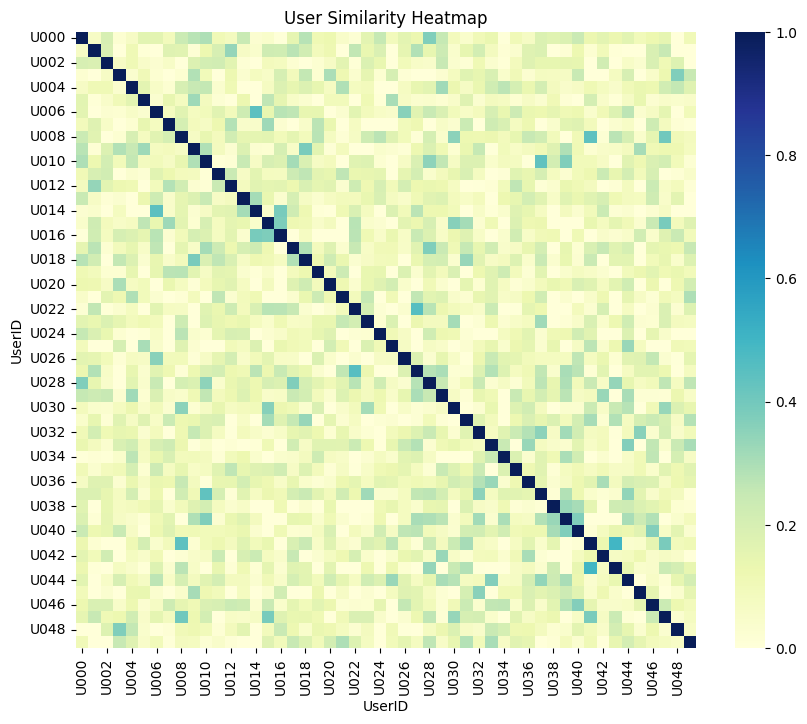

In [38]:
# Heatmap of user similarity
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap='YlGnBu')
plt.title('User Similarity Heatmap')
plt.show()

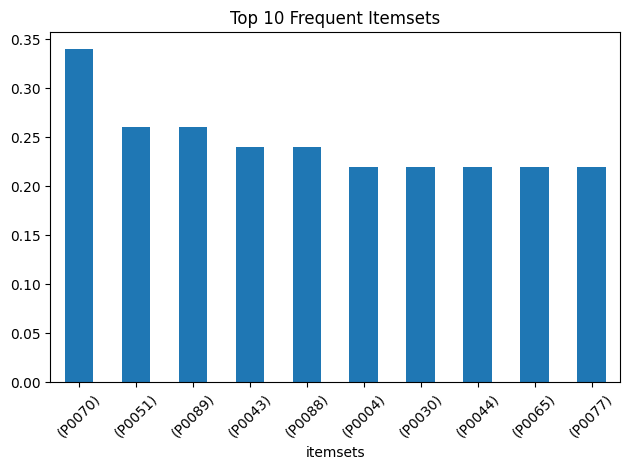

In [41]:
# Frequent itemsets bar chart
top_10_itemsets = frequent_itemsets.nlargest(10, 'support')
top_10_itemsets.plot(kind='bar', x='itemsets', y='support', legend=False)
plt.title('Top 10 Frequent Itemsets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

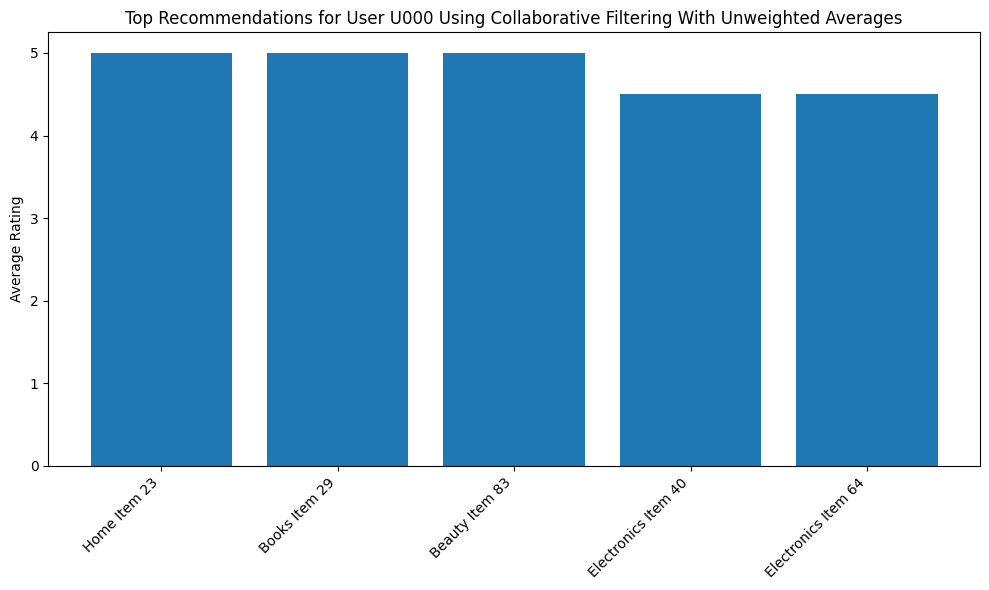

In [42]:
# Visualize top recommendations for an example user.
# Generate recommendations for an example user.
example_user = user_item_matrix_filled.index[0]
top_recs = recommend_products(example_user, user_item_matrix_filled, similarity_df, product_data, return_details=True, weighted=False)

plt.figure(figsize=(10, 6))
plt.bar(top_recs['ProductName'], top_recs['RecScore'])
plt.title(f"Top Recommendations for User {example_user} Using Collaborative Filtering With Unweighted Averages")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Rating")
plt.tight_layout()
plt.savefig("top_recommendations.png")
plt.show()

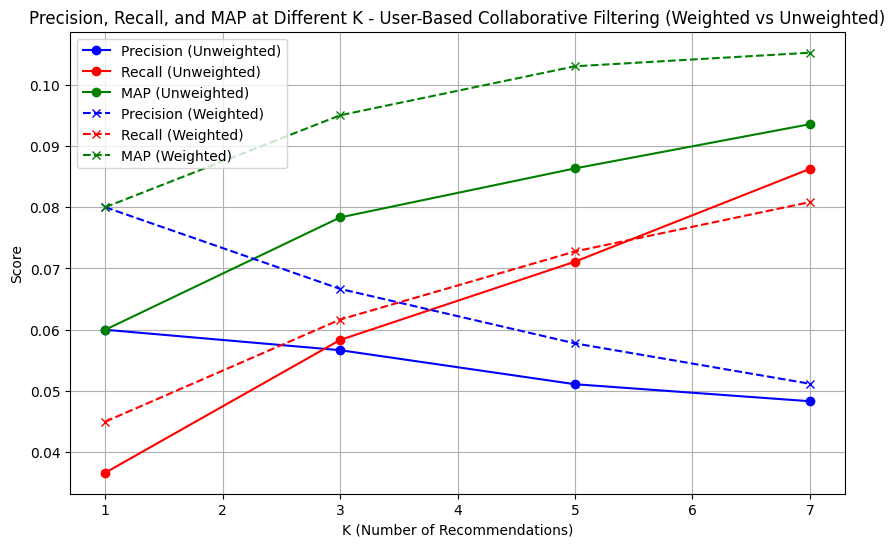

In [43]:
# Plot precision, recall, and MAP scores for different k using user-based collaborative filtering
plt.figure(figsize=(10, 6))

# Unweighted scores
plt.plot(ks_user, precision_scores_list, label='Precision (Unweighted)', color='b', marker='o', linestyle='-')
plt.plot(ks_user, recall_scores_list, label='Recall (Unweighted)', color='r', marker='o', linestyle='-')
plt.plot(ks_user, map_scores_list, label='MAP (Unweighted)', color='g', marker='o', linestyle='-')

# Weighted scores
plt.plot(ks_user, precision_scores_list_weighted, label='Precision (Weighted)', color='b', marker='x', linestyle='--')
plt.plot(ks_user, recall_scores_list_weighted, label='Recall (Weighted)', color='r', marker='x', linestyle='--')
plt.plot(ks_user, map_scores_list_weighted, label='MAP (Weighted)', color='g', marker='x', linestyle='--')

plt.xlabel('K (Number of Recommendations)')
plt.ylabel('Score')
plt.title('Precision, Recall, and MAP at Different K - User-Based Collaborative Filtering (Weighted vs Unweighted)')
plt.legend()
plt.grid(True)
plt.show()

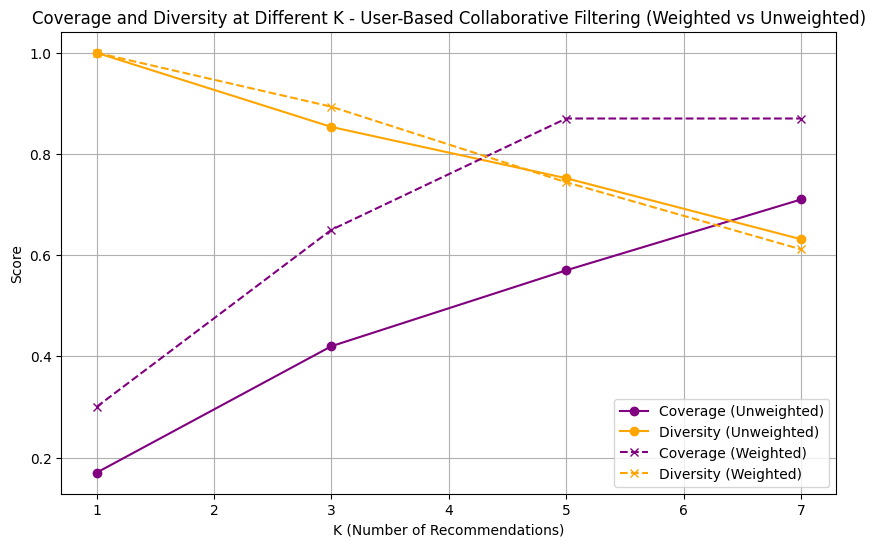

In [44]:
# Plot coverage and diversity scores for different k using user-based collaborative filtering
plt.figure(figsize=(10, 6))

# Unweighted scores
plt.plot(ks_user, coverage_list, label='Coverage (Unweighted)', color='purple', marker='o', linestyle='-')
plt.plot(ks_user, diversity_list, label='Diversity (Unweighted)', color='orange', marker='o', linestyle='-')

# Weighted scores
plt.plot(ks_user, coverage_list_weighted, label='Coverage (Weighted)', color='purple', marker='x', linestyle='--')
plt.plot(ks_user, diversity_list_weighted, label='Diversity (Weighted)', color='orange', marker='x', linestyle='--')

plt.xlabel('K (Number of Recommendations)')
plt.ylabel('Score')
plt.title('Coverage and Diversity at Different K - User-Based Collaborative Filtering (Weighted vs Unweighted)')
plt.legend()
plt.grid(True)
plt.show()

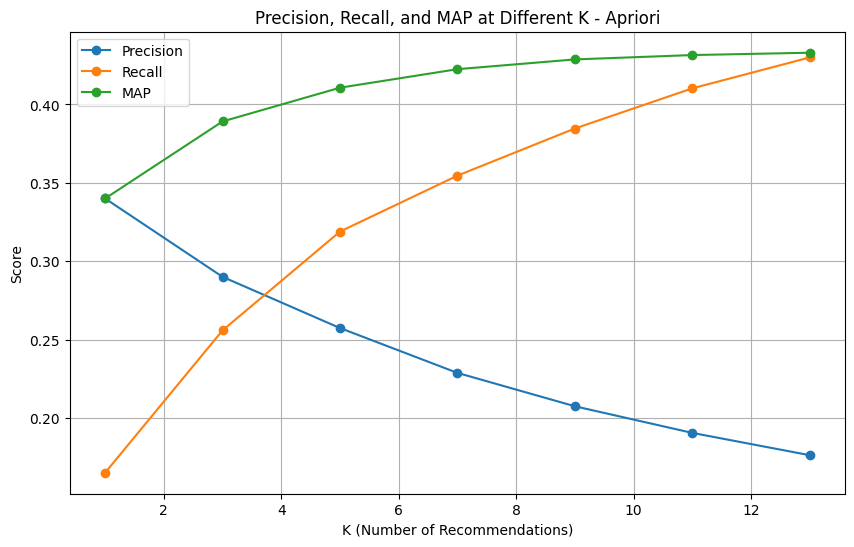

In [45]:
# Plot precision, recall, and MAP scores for different k using Apriori
plt.figure(figsize=(10, 6))
plt.plot(ks_apriori, precision_scores_list_apriori, label='Precision', marker='o')
plt.plot(ks_apriori, recall_scores_list_apriori, label='Recall', marker='o')
plt.plot(ks_apriori, map_scores_list_apriori, label='MAP', marker='o')

plt.xlabel('K (Number of Recommendations)')
plt.ylabel('Score')
plt.title('Precision, Recall, and MAP at Different K - Apriori')
plt.legend()
plt.grid(True)
plt.show()

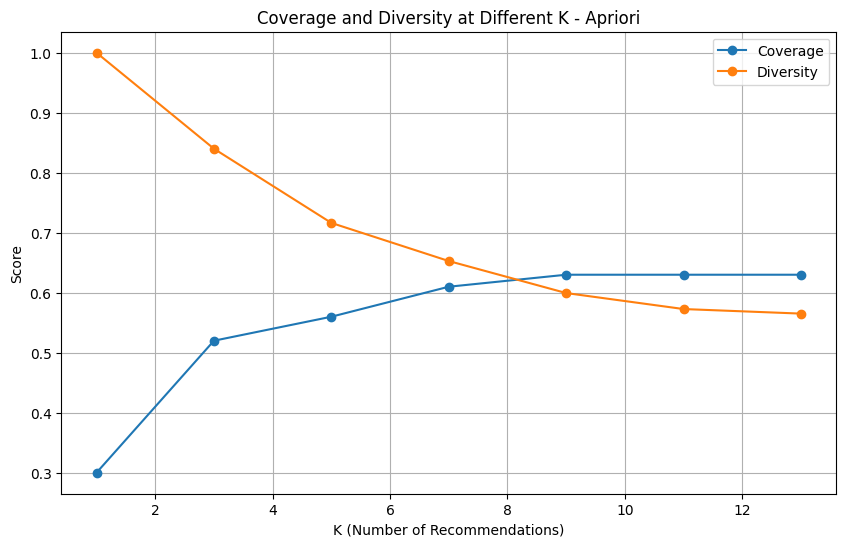

In [46]:
# Plot coverage and diversity scores for different k using Apriori
plt.figure(figsize=(10, 6))
plt.plot(ks_apriori, coverage_list_apriori, label='Coverage', marker='o')
plt.plot(ks_apriori, diversity_list_apriori, label='Diversity', marker='o')

plt.xlabel('K (Number of Recommendations)')
plt.ylabel('Score')
plt.title('Coverage and Diversity at Different K - Apriori')
plt.legend()
plt.grid(True)
plt.show()

Step:
* Top-5 product recommendations for each user group.

We will create user groups using k-means clustering and the user-item matrix.

In [50]:
# Use k-means clustering to create user groups based on their item ratings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
user_item_scaled = scaler.fit_transform(user_item_matrix_filled)

# Modify the number of clusters if needed
kmeans = KMeans(n_clusters=4, random_state=42)
user_clusters = kmeans.fit_predict(user_item_scaled)

user_cluster_df = pd.DataFrame({
    'UserID': user_item_matrix_filled.index,
    'Cluster': user_clusters
})

# Merge user_data with cluster labels
user_item_cluster_df = pd.merge(user_data, user_cluster_df, on='UserID')

print("-- Cluster count from k-means clustering using user-item matrix --")
print(user_cluster_df.groupby(['Cluster']).count())

user_item_cluster_df = pd.merge(user_data, user_cluster_df, on='UserID')
highly_rated_df = user_item_cluster_df[user_item_cluster_df['Rating'] >= 3]
highly_rated_with_category = pd.merge(highly_rated_df, product_data[['ProductID', 'Category']], on='ProductID', how='left')
highly_rated_with_category = highly_rated_with_category.rename(columns={'Category_y': 'Category'})

# Calculate the proportion of categories for each cluster
category_proportions = highly_rated_with_category.groupby(['Cluster', 'Category']).size().unstack(fill_value=0)

# Normalize the proportions within each cluster
category_proportions_normalized = category_proportions.div(category_proportions.sum(axis=1), axis=0)

print("\n-- Category proportion --")
print(category_proportions_normalized)

-- Cluster count from k-means clustering using user-item matrix --
         UserID
Cluster        
0             2
1            43
2             1
3             4

-- Category proportion --
Category    Beauty     Books  Clothing  Electronics      Home      Toys
Cluster                                                                
0         0.217391  0.391304  0.043478     0.043478  0.173913  0.130435
1         0.130682  0.193182  0.161932     0.261364  0.096591  0.156250
2         0.000000  0.333333  0.166667     0.416667  0.000000  0.083333
3         0.105263  0.236842  0.078947     0.289474  0.078947  0.210526


We will also create clusters based on each user's average ratings per category.

In [51]:
# Pivot table to have one user ID per row, with one category's average rating in each column
user_cat_matrix = user_category_agg.pivot_table(index='UserID', columns='Category', values='AverageRating').fillna(0)
user_cat_scaled = scaler.fit_transform(user_cat_matrix)

# Use k-means clustering to create user groups based on their average ratings of categories
kmeans_cat = KMeans(n_clusters=5, random_state=42)
cat_clusters = kmeans_cat.fit_predict(user_cat_scaled)

cat_cluster_df = pd.DataFrame({
    'UserID': user_cat_matrix.index,
    'Cluster': cat_clusters
})

# Merge user_data with cluster labels
user_cat_cluster_df = pd.merge(user_data, cat_cluster_df, on='UserID')

print("-- Cluster count from k-means clustering using user category aggregation data --")
print(cat_cluster_df.groupby(['Cluster']).count())

user_cat_matrix_binary = user_cat_matrix >= 3
user_cat_matrix_binary['Cluster'] = cat_clusters

# Group by 'Cluster', and calculate the proportion of '1's (highly-rated categories) in each category
category_proportions = user_cat_matrix_binary.groupby('Cluster').sum() / user_cat_matrix_binary.groupby('Cluster').sum().sum(axis=1).values[:, None]

print("\n-- Category proportion --")
print(category_proportions)

-- Cluster count from k-means clustering using user category aggregation data --
         UserID
Cluster        
0             8
1            11
2            12
3            11
4             8

-- Category proportion --
Category    Beauty     Books  Clothing  Electronics      Home      Toys
Cluster                                                                
0         0.171429  0.228571  0.171429     0.085714  0.142857  0.200000
1         0.000000  0.218750  0.187500     0.187500  0.218750  0.187500
2         0.370370  0.074074  0.111111     0.037037  0.185185  0.222222
3         0.131579  0.026316  0.105263     0.289474  0.210526  0.236842
4         0.136364  0.318182  0.227273     0.227273  0.000000  0.090909


In [52]:
# For each cluster, get top-n highest rated products. Settle ties with popularity (number of ratings).
def top_n_per_cluster(data_with_clusters, n=5):
    group_recs = data_with_clusters.groupby(['Cluster', 'ProductID'])['Rating'].agg(['mean', 'count']).reset_index()
    group_recs = group_recs.rename(columns={'mean': 'AverageRating'})
    group_recs = group_recs.sort_values(['Cluster', 'AverageRating', 'count'], ascending=[True, False, False])

    # Get top n per cluster
    top_by_group = group_recs.groupby('Cluster').head(n)
    top_named = top_by_group.merge(product_data, on='ProductID')[['Cluster', 'ProductID', 'ProductName', 'AverageRating']]
    return top_named

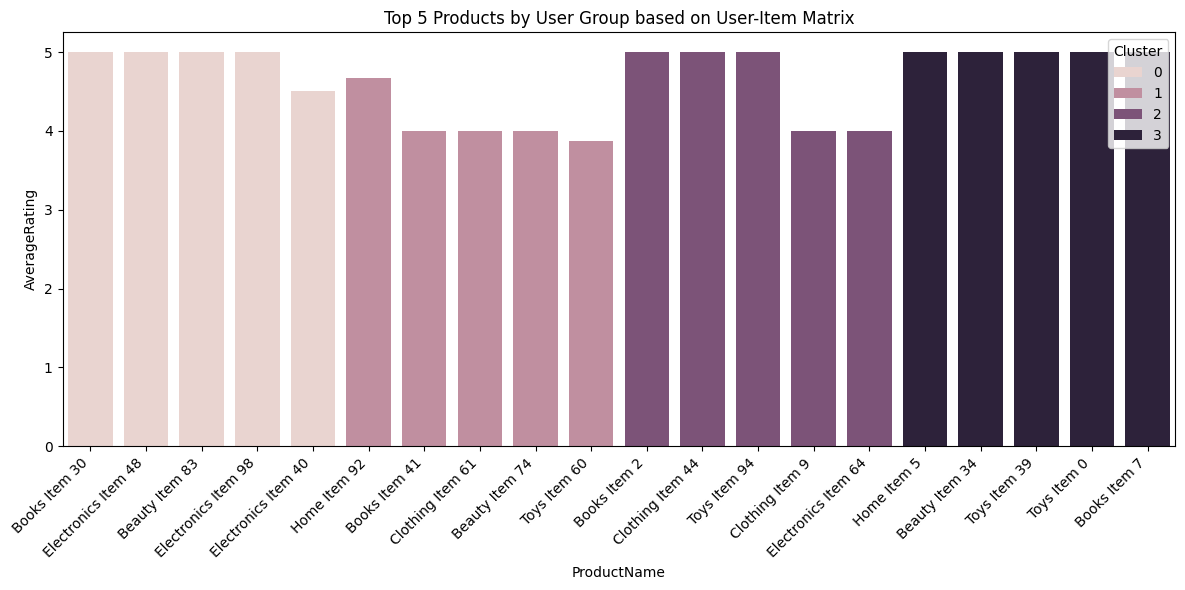

In [53]:
# Plot the top 5 products for each user group using bar charts.
top5_user_item = top_n_per_cluster(user_item_cluster_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=top5_user_item, x='ProductName', y='AverageRating', hue='Cluster')
plt.title('Top 5 Products by User Group based on User-Item Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Currently, if a product appears in the top 5 for multiple clusters, bars from different clusters will be together for that product, instead of grouped together per cluster. To visually distinguish products across clusters, we can add spaces before each product name; the line to do this is commented out below.

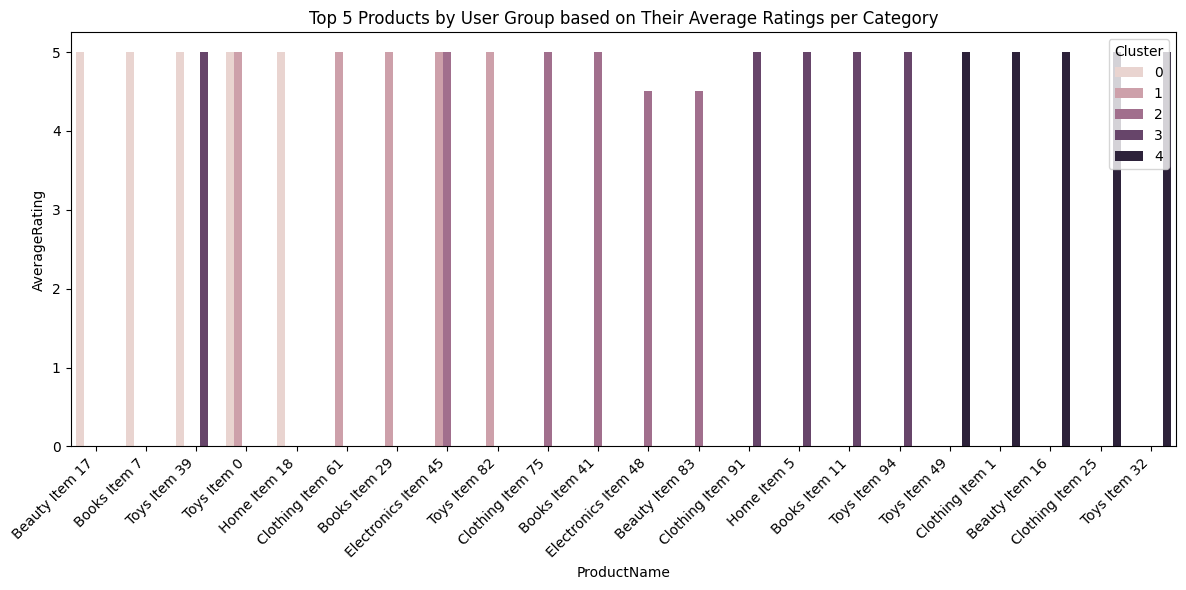

In [54]:
# Plot the top 5 products for each user group using bar charts.
top5_user_cat = top_n_per_cluster(user_cat_cluster_df)

# Uncomment this line so the bars from each cluster always appear together (this makes the bars thicker)
# top5_user_cat['ProductName'] = np.strings.multiply(' ', top5_user_cat['Cluster']) + top5_user_cat['ProductName']

plt.figure(figsize=(12, 6))
sns.barplot(data=top5_user_cat, x='ProductName', y='AverageRating', hue='Cluster')
plt.title('Top 5 Products by User Group based on Their Average Ratings per Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()